In [82]:
from datetime import date
import polars as pl
import polars.selectors as cs
import xarray as xr
import numpy as np
from disfor.data_fetcher import DATA_GETTER
from nrt.monitor.ewma import EWMA
from nrt.monitor.ccdc import CCDC
from nrt.monitor.iqr import IQR

In [2]:
labels = pl.read_parquet("/home/jonas/.cache/disfor/0.1.0/labels.parquet")
pixel_data = pl.read_parquet("/home/jonas/.cache/disfor/0.1.0/pixel_data.parquet")
labels

original_sample_id,dataset,label,original_label,start,end,sample_id,start_next_label
i64,str,u16,str,"datetime[ms, UTC]","datetime[ms, UTC]",u16,"datetime[ms, UTC]"
0,"""Evoland""",110,"""0""",2016-11-10 00:00:00 UTC,2022-03-09 00:00:00 UTC,0,2022-04-08 00:00:00 UTC
0,"""Evoland""",212,"""6""",2022-04-08 00:00:00 UTC,2022-04-08 23:59:59 UTC,0,2024-04-02 00:00:00 UTC
0,"""Evoland""",211,"""5""",2024-04-02 00:00:00 UTC,2024-04-02 23:59:59 UTC,0,null
1,"""Evoland""",110,"""0""",2016-11-10 00:00:00 UTC,2023-05-03 00:00:00 UTC,1,2023-06-22 00:00:00 UTC
1,"""Evoland""",211,"""5""",2023-06-22 00:00:00 UTC,2023-06-22 23:59:59 UTC,1,null
…,…,…,…,…,…,…,…
16071,"""Windthrow""",243,"""7""",2020-03-11 00:00:00 UTC,2020-03-11 23:59:59 UTC,3821,2020-03-16 00:00:00 UTC
16071,"""Windthrow""",120,"""3""",2020-03-16 00:00:00 UTC,2024-12-30 00:00:00 UTC,3821,null
16076,"""Windthrow""",110,"""0""",2017-08-04 00:00:00 UTC,2020-01-21 00:00:00 UTC,3822,2020-03-11 00:00:00 UTC


In [8]:
# define cutoff history/monitoring
monitor_start = date(year=2020, month=1, day=1)

first_disturbed = pl.col("start").filter(pl.col("label") >= 200).first()
exclude_disturbance_types = ~pl.col.label.is_in([
    213, 
    232,
    244,
    245
]).over("sample_id")
# Filter: 
# - Everything disturbed before cutoff
# - Evoland
# - Samples with excluded disturbance types
selected_samples = (labels
    .sort("sample_id", "start")
    .filter(
        pl.col.dataset.ne("Evoland"),
        #((pl.col.start < monitor_start) & (pl.col.label >= 200)).over("sample_id"), # TODO: Discard entire sample, if condition is met
        (~(first_disturbed < monitor_start) | first_disturbed.is_null()).over("sample_id"),
        exclude_disturbance_types
    )
    .select(
        "sample_id",
        # get first disturbed date (if there's disturbance)
        first_disturbed=pl.col("start").filter(pl.col("label") >= 200).first().over("sample_id"),
    )
    .with_columns(
        true_disturbed=pl.col.first_disturbed.is_not_null()
    )
    .unique("sample_id")
)
selected_samples


sample_id,first_disturbed,true_disturbed
u16,"datetime[ms, UTC]",bool
913,null,false
914,null,false
915,null,false
916,null,false
917,null,false
…,…,…
3818,2020-02-15 00:00:00 UTC,true
3819,2020-02-15 00:00:00 UTC,true
3820,2020-02-15 00:00:00 UTC,true


In [9]:
# select only samples
# calculate ndmi/tcw
prepared_data = (
    pixel_data
    .filter(
        pl.col.sample_id.is_in(selected_samples["sample_id"].implode())
    )
    .with_columns(
        cs.starts_with("B").cast(pl.Int32)
    )
    .select(
        "sample_id",
        "timestamps",
        "SCL",
        ndmi=(pl.col("B08") - pl.col("B11")) / (pl.col("B08") + pl.col("B11")),
        tcw=(0.0315*pl.col("B02") + 0.2021*pl.col("B03") + 0.3102*pl.col("B04") + 0.1594*pl.col("B08") - 0.6806*pl.col("B11") - 0.6109*pl.col("B12"))
    )
)
prepared_data


sample_id,timestamps,SCL,ndmi,tcw
u16,date,u8,f64,f64
1000,2016-03-08,4,0.221601,-649.8097
1000,2016-03-11,4,0.186441,-781.8105
1000,2016-03-18,9,0.084198,-1538.7552
1000,2016-03-21,8,0.686385,3277.3374
1000,2016-03-28,8,0.220061,-663.0542
…,…,…,…,…
999,2024-12-19,5,-0.119347,-1445.3491
999,2024-12-21,5,-0.195351,-1884.4983
999,2024-12-24,5,-0.234915,-1948.7517


In [10]:
def polars_to_xarray(df: pl.DataFrame, grid_size: int = None) -> xr.Dataset:
    """
    Convert a Polars DataFrame with time-series samples to an xarray Dataset.
    
    Parameters:
    -----------
    df : pl.DataFrame
        DataFrame with columns including sample_id, timestamps, and band data (B03, B04, etc.)
    grid_size : int, optional
        Size of the square grid. If None, will be calculated to fit all samples.
    
    Returns:
    --------
    xr.Dataset
        Dataset with dimensions (time, y, x) and data variables for each band
    """
    
    # Define the bands and other columns
    band_cols = ['tcw', 'ndmi', 'SCL']
    
    # Get unique sample_ids and timestamps
    unique_samples = df['sample_id'].unique().sort()
    all_timestamps = df['timestamps'].unique().sort()
    
    n_samples = len(unique_samples)
    n_times = len(all_timestamps)
    
    # Calculate grid size if not provided
    if grid_size is None:
        grid_size = int(np.ceil(np.sqrt(n_samples)))
    
    # Create mapping from sample_id to (x, y) coordinates
    sample_to_coords = {}
    for idx, sample_id in enumerate(unique_samples):
        y_idx = idx // grid_size
        x_idx = idx % grid_size
        sample_to_coords[sample_id] = (x_idx, y_idx)
    
    # Create coordinate arrays
    x_coords = np.arange(grid_size, dtype=np.float64) * 10000 + 5272000  # Arbitrary spacing
    y_coords = np.arange(grid_size, dtype=np.float64) * 10000 + 2532000  # Arbitrary spacing
    time_coords = all_timestamps.to_numpy().astype('datetime64[ns]')
    
    # Initialize data arrays with NaN
    data_vars = {}
    for band in band_cols:
        if band == 'SCL':
            # Use uint8 for SCL, with 255 as fill value
            arr = np.full((n_times, grid_size, grid_size), 255, dtype=np.uint8)
        else:
            # Use uint16 for other bands, with 65535 as fill value
            arr = np.full((n_times, grid_size, grid_size), 65535, dtype=np.float32)
        data_vars[band] = arr
    
    # Fill in the data
    for row in df.iter_rows(named=True):
        sample_id = row['sample_id']
        timestamp = row['timestamps']
        
        # Get coordinates
        x_idx, y_idx = sample_to_coords[sample_id]
        
        # Get time index
        time_idx = np.where(all_timestamps == timestamp)[0][0]
        
        # Fill in band values
        for band in band_cols:
            data_vars[band][time_idx, y_idx, x_idx] = row[band]
    
    # Create xarray Dataset
    ds = xr.Dataset(
        data_vars={
            band: (['time', 'y', 'x'], data_vars[band])
            for band in band_cols
        },
        coords={
            'time': time_coords,
            'y': y_coords[:grid_size],
            'x': x_coords[:grid_size],
            'spatial_ref': 0  # Placeholder spatial reference
        }
    )
    
    # Add sample_id as a coordinate variable for reference
    sample_id_grid = np.full((grid_size, grid_size), -1, dtype=np.int32)
    for sample_id, (x_idx, y_idx) in sample_to_coords.items():
        sample_id_grid[y_idx, x_idx] = sample_id
    
    ds = ds.assign_coords(sample_id=(['y', 'x'], sample_id_grid))
    
    return ds


# Example usage:
ds = polars_to_xarray(prepared_data)
print(ds)
# To access data for a specific sample:
# sample_mask = ds.sample_id == 10
# sample_data = ds.where(sample_mask, drop=True)

<xarray.Dataset> Size: 76MB
Dimensions:      (time: 3362, y: 50, x: 50)
Coordinates:
  * time         (time) datetime64[ns] 27kB 2015-07-04 2015-07-06 ... 2025-01-01
  * y            (y) float64 400B 2.532e+06 2.542e+06 ... 3.012e+06 3.022e+06
  * x            (x) float64 400B 5.272e+06 5.282e+06 ... 5.752e+06 5.762e+06
    spatial_ref  int64 8B 0
    sample_id    (y, x) int32 10kB 913 914 915 916 917 918 ... -1 -1 -1 -1 -1 -1
Data variables:
    tcw          (time, y, x) float32 34MB 6.554e+04 6.554e+04 ... 6.554e+04
    ndmi         (time, y, x) float32 34MB 6.554e+04 6.554e+04 ... 6.554e+04
    SCL          (time, y, x) uint8 8MB 255 255 255 255 255 ... 255 255 255 255


In [49]:
df = prepared_data
grid_size = None
band_cols = ["tcw", "ndmi", "SCL"]

# Get unique sample_ids and timestamps, sorted
unique_samples = df['sample_id'].unique(maintain_order=False).sort()
all_timestamps = df['timestamps'].unique(maintain_order=False).sort()

n_samples = len(unique_samples)
n_times = len(all_timestamps)

# Create mapping from sample_id to x index using Polars
sample_mapping = pl.DataFrame({
    'sample_id': unique_samples,
    'x_idx': pl.arange(0, n_samples, eager=True)
})

# Create mapping from timestamp to time index
time_mapping = pl.DataFrame({
    'timestamps': all_timestamps,
    'time_idx': pl.arange(0, n_times, eager=True)
})

# Join the mappings to the original dataframe
df_indexed = (
    df
    .join(sample_mapping, on='sample_id', how='left')
    .join(time_mapping, on='timestamps', how='left')
    .select(['time_idx', 'x_idx'] + band_cols)
)

# Create coordinate arrays
x_coords = np.arange(n_samples, dtype=np.float64) * 10000 + 5272000
y_coords = np.array([2532000], dtype=np.float64)
time_coords = all_timestamps.to_numpy().astype('datetime64[ns]')

# Initialize data arrays with fill values
data_vars = {}
for band in band_cols:
    if band == 'SCL':
        arr = np.full((n_times, 1, n_samples), 255, dtype=np.uint8)
    else:
        arr = np.full((n_times, 1, n_samples), np.nan, dtype=np.float32)
    data_vars[band] = arr

# Extract indices and values as numpy arrays for vectorized assignment
time_indices = df_indexed['time_idx'].to_numpy()
x_indices = df_indexed['x_idx'].to_numpy()
y_idx = 0  # Always 0 for our 1D layout

# Vectorized assignment for each band
for band in band_cols:
    values = df_indexed[band].to_numpy()
    data_vars[band][time_indices, y_idx, x_indices] = values

# Create xarray Dataset
ds = xr.Dataset(
    data_vars={
        band: (['time', 'y', 'x'], data_vars[band])
        for band in band_cols
    },
    coords={
        'time': time_coords,
        'y': y_coords,
        'x': x_coords,
        'spatial_ref': 0  # Placeholder spatial reference
    }
)

# Add sample_id as a coordinate variable for reference (vectorized)
sample_id_array = unique_samples.to_numpy().reshape(1, -1)
ds = ds.assign_coords(sample_id=(['y', 'x'], sample_id_array))

In [50]:
ds

<xarray.Dataset> Size: 73MB
Dimensions:      (time: 3362, y: 1, x: 2403)
Coordinates:
  * time         (time) datetime64[ns] 27kB 2015-07-04 2015-07-06 ... 2025-01-01
  * y            (y) float64 8B 2.532e+06
  * x            (x) float64 19kB 5.272e+06 5.282e+06 ... 2.928e+07 2.929e+07
    spatial_ref  int64 8B 0
    sample_id    (y, x) uint16 5kB 913 914 915 916 917 ... 3819 3820 3821 3822
Data variables:
    tcw          (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan
    ndmi         (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan
    SCL          (time, y, x) uint8 8MB 255 255 255 255 255 ... 255 255 255 255

In [51]:
single_sample = ds.isel(x=1)
raw_ndmi = single_sample.ndmi.values.flatten()
ndmi = raw_ndmi[~np.isnan(raw_ndmi)]
ndmi 

array([0.2088839 , 0.25482175, 0.21156149, ..., 0.40400338, 0.36900997,
       0.44175136], shape=(1195,), dtype=float32)

In [47]:
sample_id_ = single_sample.sample_id.values[0]

In [48]:
prepared_data.filter(sample_id=sample_id_)

sample_id,timestamps,SCL,ndmi,tcw
u16,date,u8,f64,f64
914,2016-03-08,4,0.208884,-897.2041
914,2016-03-11,4,0.254822,-765.3944
914,2016-03-18,9,0.211561,-981.6888
914,2016-03-21,7,0.286544,-641.1346
914,2016-03-28,4,0.222271,-1029.6449
…,…,…,…,…
914,2024-12-19,9,0.154894,-531.061
914,2024-12-21,4,0.440772,-503.8461
914,2024-12-24,4,0.404003,-500.5206


In [52]:
ds = ds.where(ds.SCL.isin([4, 5, 6, 7]))

In [53]:
sample_mask = (ds.sample_id != -1).values

In [ ]:
value_band = "tcw"

history = ds[value_band].sel(time=slice(None, monitor_start))
monitor = ds[value_band].sel(time=slice(monitor_start, None))

In [56]:
# exclude any that have too few values
mask = (np.count_nonzero(~history.isnull(), axis=0) > 10) & sample_mask

In [57]:
# Instantiate
nrt_class = EWMA(
    mask=mask,
    trend=False,
    harmonic_order=2,
    sensitivity=2
)

In [58]:
nrt_class.fit(dataarray=history)

In [59]:
# Monitor new observations
for array, _date in zip(monitor.values, monitor.time.values.astype('datetime64[s]').tolist()):
    nrt_class.monitor(array=array, date=_date)

In [60]:
nrt_class.detection_date

array([[20081, 20066, 19946, ..., 20087, 20082, 20087]],
      shape=(1, 2403), dtype=uint16)

In [61]:
# calculate accuracy. 
# convert from xarray to table
pred = pl.DataFrame(
    {
        "sample_id": ds.sample_id.values.flatten(),
        "detection_date": nrt_class.detection_date.flatten(),
    }
).filter(
    pl.col.sample_id!=-1
).with_columns(
    pred_disturbed=pl.col.detection_date!=0
)
pred

sample_id,detection_date,pred_disturbed
u16,u16,bool
913,20081,true
914,20066,true
915,19946,true
916,19828,true
917,20066,true
…,…,…
3818,20087,true
3819,20087,true
3820,20087,true


In [62]:
results = pred.join(
    selected_samples.unique("sample_id"),
    on="sample_id"
)
results

sample_id,detection_date,pred_disturbed,first_disturbed,true_disturbed
u16,u16,bool,"datetime[ms, UTC]",bool
913,20081,true,null,false
914,20066,true,null,false
915,19946,true,null,false
916,19828,true,null,false
917,20066,true,null,false
…,…,…,…,…
3818,20087,true,2020-02-15 00:00:00 UTC,true
3819,20087,true,2020-02-15 00:00:00 UTC,true
3820,20087,true,2020-02-15 00:00:00 UTC,true


In [63]:
from sklearn.metrics import accuracy_score, f1_score
accuracy_score(results["true_disturbed"], results["pred_disturbed"])

0.2068248023304203

In [64]:
import optuna

/home/jonas/Documents/Projects/2025/DISFOR/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [94]:
def ewma_objective(trial: optuna.Trial) -> float:
    """
    Objective function for Optuna hyperparameter optimization.
    
    Args:
        trial: Optuna trial object
        
    Returns:
        Objective value to minimize (e.g., false positive rate, detection delay)
    """
    
    # Define hyperparameter search spaces
    params = {
        'trend': trial.suggest_categorical('trend', [True, False]),
        'harmonic_order': trial.suggest_int('harmonic_order', 1, 5),
        'sensitivity': trial.suggest_float('sensitivity', 0, 10.0),
        'lambda_': trial.suggest_float('lambda_', 0.1, 0.9, step=0.1),
        'threshold_outlier': trial.suggest_float('threshold_outlier', 0, 10.0)
    }
    
    # Initialize EWMA with suggested parameters
    nrt_class = EWMA(
        trend=params['trend'],
        harmonic_order=params['harmonic_order'],
        mask=mask,
        sensitivity=params['sensitivity'],
        lambda_=params['lambda_'],
        threshold_outlier=params['threshold_outlier']
    )
    nrt_class.fit(dataarray=history)
    # Monitor new observations
    for array, _date in zip(monitor.values, monitor.time.values.astype('datetime64[s]').tolist()):
        nrt_class.monitor(array=array, date=_date)

    pred = pl.DataFrame(
        {
            "sample_id": ds.sample_id.values.flatten(),
            "detection_date": nrt_class.detection_date.flatten(),
        }
    ).filter(
        pl.col.sample_id!=-1
    ).with_columns(
        pred_disturbed=pl.col.detection_date!=0
    )

    results = pred.join(
        selected_samples.unique("sample_id"),
        on="sample_id"
    )

    score = f1_score(results["true_disturbed"], results["pred_disturbed"])
    return score

In [95]:
# Create study
study_ewma = optuna.create_study(
    direction="maximize",
    study_name="F1-EWMA",
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Run optimization
study_ewma.optimize(ewma_objective, n_trials=100, show_progress_bar=True)

[I 2025-12-29 20:13:55,698] A new study created in memory with name: F1-EWMA
Best trial: 0. Best value: 0:   1%|          | 1/100 [00:04<07:47,  4.73s/it]

[I 2025-12-29 20:14:00,424] Trial 0 finished with value: 0.0 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 5.986584841970366, 'lambda_': 0.2, 'threshold_outlier': 1.5599452033620265}. Best is trial 0 with value: 0.0.


Best trial: 1. Best value: 0.483871:   2%|▏         | 2/100 [00:09<07:53,  4.84s/it]

[I 2025-12-29 20:14:05,339] Trial 1 finished with value: 0.4838709677419355 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 7.080725777960454, 'lambda_': 0.1, 'threshold_outlier': 9.699098521619943}. Best is trial 1 with value: 0.4838709677419355.


Best trial: 1. Best value: 0.483871:   3%|▎         | 3/100 [00:14<07:55,  4.90s/it]

[I 2025-12-29 20:14:10,315] Trial 2 finished with value: 0.33622785689475515 and parameters: {'trend': True, 'harmonic_order': 1, 'sensitivity': 1.8340450985343382, 'lambda_': 0.30000000000000004, 'threshold_outlier': 5.247564316322379}. Best is trial 1 with value: 0.4838709677419355.


Best trial: 1. Best value: 0.483871:   4%|▍         | 4/100 [00:19<08:05,  5.06s/it]

[I 2025-12-29 20:14:15,625] Trial 3 finished with value: 0.3397923875432526 and parameters: {'trend': True, 'harmonic_order': 4, 'sensitivity': 1.3949386065204183, 'lambda_': 0.30000000000000004, 'threshold_outlier': 3.663618432936917}. Best is trial 1 with value: 0.4838709677419355.


Best trial: 1. Best value: 0.483871:   5%|▌         | 5/100 [00:24<07:52,  4.97s/it]

[I 2025-12-29 20:14:20,442] Trial 4 finished with value: 0.0 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 5.142344384136116, 'lambda_': 0.6, 'threshold_outlier': 0.46450412719997725}. Best is trial 1 with value: 0.4838709677419355.


Best trial: 1. Best value: 0.483871:   6%|▌         | 6/100 [00:30<08:00,  5.11s/it]

[I 2025-12-29 20:14:25,825] Trial 5 finished with value: 0.0 and parameters: {'trend': True, 'harmonic_order': 1, 'sensitivity': 9.488855372533333, 'lambda_': 0.9, 'threshold_outlier': 8.08397348116461}. Best is trial 1 with value: 0.4838709677419355.


Best trial: 1. Best value: 0.483871:   7%|▋         | 7/100 [00:36<08:27,  5.46s/it]

[I 2025-12-29 20:14:32,006] Trial 6 finished with value: 0.35519591141396933 and parameters: {'trend': True, 'harmonic_order': 4, 'sensitivity': 4.4015249373960135, 'lambda_': 0.2, 'threshold_outlier': 4.951769101112702}. Best is trial 1 with value: 0.4838709677419355.


Best trial: 7. Best value: 0.574359:   8%|▊         | 8/100 [00:42<08:35,  5.60s/it]

[I 2025-12-29 20:14:37,912] Trial 7 finished with value: 0.5743589743589743 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 6.62522284353982, 'lambda_': 0.30000000000000004, 'threshold_outlier': 5.200680211778108}. Best is trial 7 with value: 0.5743589743589743.


Best trial: 7. Best value: 0.574359:   9%|▉         | 9/100 [00:49<09:09,  6.04s/it]

[I 2025-12-29 20:14:44,909] Trial 8 finished with value: 0.3537848605577689 and parameters: {'trend': True, 'harmonic_order': 5, 'sensitivity': 7.7513282336111455, 'lambda_': 0.9, 'threshold_outlier': 8.948273504276488}. Best is trial 7 with value: 0.5743589743589743.


Best trial: 7. Best value: 0.574359:  10%|█         | 10/100 [00:57<10:01,  6.68s/it]

[I 2025-12-29 20:14:53,034] Trial 9 finished with value: 0.33345310815666546 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.959828624191452, 'lambda_': 0.1, 'threshold_outlier': 3.2533033076326436}. Best is trial 7 with value: 0.5743589743589743.


Best trial: 7. Best value: 0.574359:  11%|█         | 11/100 [01:08<11:46,  7.94s/it]

[I 2025-12-29 20:15:03,817] Trial 10 finished with value: 0.4117647058823529 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 9.695371107878657, 'lambda_': 0.5, 'threshold_outlier': 7.15169612196795}. Best is trial 7 with value: 0.5743589743589743.


Best trial: 7. Best value: 0.574359:  12%|█▏        | 12/100 [01:20<13:24,  9.14s/it]

[I 2025-12-29 20:15:15,701] Trial 11 finished with value: 0.42950391644908614 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 6.95782079171106, 'lambda_': 0.5, 'threshold_outlier': 9.898468933199815}. Best is trial 7 with value: 0.5743589743589743.


Best trial: 7. Best value: 0.574359:  13%|█▎        | 13/100 [01:29<13:21,  9.22s/it]

[I 2025-12-29 20:15:25,097] Trial 12 finished with value: 0.34838709677419355 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 3.604851325330766, 'lambda_': 0.1, 'threshold_outlier': 6.615986789426712}. Best is trial 7 with value: 0.5743589743589743.


Best trial: 13. Best value: 0.584184:  14%|█▍        | 14/100 [01:39<13:40,  9.54s/it]

[I 2025-12-29 20:15:35,375] Trial 13 finished with value: 0.5841836734693877 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 7.826573039835715, 'lambda_': 0.4, 'threshold_outlier': 5.726236347885992}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  15%|█▌        | 15/100 [01:56<16:35, 11.71s/it]

[I 2025-12-29 20:15:52,118] Trial 14 finished with value: 0.44879518072289154 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 8.783518313217947, 'lambda_': 0.4, 'threshold_outlier': 5.396201068027977}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  16%|█▌        | 16/100 [02:09<17:03, 12.19s/it]

[I 2025-12-29 20:16:05,418] Trial 15 finished with value: 0.0 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 7.683022827769082, 'lambda_': 0.7000000000000001, 'threshold_outlier': 3.638333065661735}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  17%|█▋        | 17/100 [02:20<16:04, 11.62s/it]

[I 2025-12-29 20:16:15,704] Trial 16 finished with value: 0.48361252731245447 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 5.917861577459636, 'lambda_': 0.4, 'threshold_outlier': 6.222998330881175}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  18%|█▊        | 18/100 [02:31<16:01, 11.72s/it]

[I 2025-12-29 20:16:27,676] Trial 17 finished with value: 0.0 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 3.08868272157813, 'lambda_': 0.7000000000000001, 'threshold_outlier': 2.1042942813867445}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  19%|█▉        | 19/100 [02:42<15:12, 11.26s/it]

[I 2025-12-29 20:16:37,871] Trial 18 finished with value: 0.5584255842558425 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 8.516572712621995, 'lambda_': 0.4, 'threshold_outlier': 7.701591005447989}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  20%|██        | 20/100 [02:52<14:33, 10.92s/it]

[I 2025-12-29 20:16:47,987] Trial 19 finished with value: 0.5612968591691996 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 6.202031716446972, 'lambda_': 0.30000000000000004, 'threshold_outlier': 4.485480568900761}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  21%|██        | 21/100 [03:02<13:59, 10.63s/it]

[I 2025-12-29 20:16:57,948] Trial 20 finished with value: 0.3425414364640884 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 0.15510381994227185, 'lambda_': 0.6, 'threshold_outlier': 5.979057979393733}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  22%|██▏       | 22/100 [03:13<13:59, 10.77s/it]

[I 2025-12-29 20:17:09,030] Trial 21 finished with value: 0.5477707006369427 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 6.135223270326864, 'lambda_': 0.30000000000000004, 'threshold_outlier': 4.055742266889619}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  23%|██▎       | 23/100 [03:25<14:16, 11.12s/it]

[I 2025-12-29 20:17:20,965] Trial 22 finished with value: 0.46734006734006733 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 5.036590174052183, 'lambda_': 0.2, 'threshold_outlier': 4.369953380785133}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  24%|██▍       | 24/100 [03:36<14:00, 11.06s/it]

[I 2025-12-29 20:17:31,906] Trial 23 finished with value: 0.0 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 6.667088731563819, 'lambda_': 0.30000000000000004, 'threshold_outlier': 2.783373412812331}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  25%|██▌       | 25/100 [03:44<12:52, 10.30s/it]

[I 2025-12-29 20:17:40,433] Trial 24 finished with value: 0.14571948998178508 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 8.176932563253548, 'lambda_': 0.4, 'threshold_outlier': 4.491306359038045}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  26%|██▌       | 26/100 [03:56<13:11, 10.69s/it]

[I 2025-12-29 20:17:52,029] Trial 25 finished with value: 0.37073608617594256 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 4.102913007505851, 'lambda_': 0.2, 'threshold_outlier': 5.453504985180592}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  27%|██▋       | 27/100 [04:09<13:48, 11.35s/it]

[I 2025-12-29 20:18:04,917] Trial 26 finished with value: 0.3757380568974772 and parameters: {'trend': True, 'harmonic_order': 2, 'sensitivity': 5.534367228032271, 'lambda_': 0.5, 'threshold_outlier': 6.975056631119515}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  28%|██▊       | 28/100 [04:21<13:49, 11.52s/it]

[I 2025-12-29 20:18:16,832] Trial 27 finished with value: 0.5558794946550049 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 7.080584671555523, 'lambda_': 0.30000000000000004, 'threshold_outlier': 6.0562329907217425}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  29%|██▉       | 29/100 [04:31<13:03, 11.04s/it]

[I 2025-12-29 20:18:26,751] Trial 28 finished with value: 0.0 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 9.19544491666009, 'lambda_': 0.6, 'threshold_outlier': 2.667252908588786}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  30%|███       | 30/100 [04:41<12:46, 10.95s/it]

[I 2025-12-29 20:18:37,487] Trial 29 finished with value: 0.0 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 6.232228774210711, 'lambda_': 0.4, 'threshold_outlier': 1.1315151444651188}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  31%|███       | 31/100 [04:52<12:28, 10.85s/it]

[I 2025-12-29 20:18:48,121] Trial 30 finished with value: 0.5586592178770949 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 7.835184236564741, 'lambda_': 0.2, 'threshold_outlier': 7.950161289505624}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  32%|███▏      | 32/100 [05:02<12:12, 10.77s/it]

[I 2025-12-29 20:18:58,691] Trial 31 finished with value: 0.5410122164048866 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 7.777300233709625, 'lambda_': 0.2, 'threshold_outlier': 8.984730577220269}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  33%|███▎      | 33/100 [05:14<12:25, 11.12s/it]

[I 2025-12-29 20:19:10,631] Trial 32 finished with value: 0.5256087321578505 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 6.561055734591113, 'lambda_': 0.1, 'threshold_outlier': 4.654244994256224}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 13. Best value: 0.584184:  34%|███▍      | 34/100 [05:25<12:05, 11.00s/it]

[I 2025-12-29 20:19:21,344] Trial 33 finished with value: 0.5187032418952618 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 7.320443104507742, 'lambda_': 0.2, 'threshold_outlier': 8.051845341156776}. Best is trial 13 with value: 0.5841836734693877.


Best trial: 34. Best value: 0.594595:  35%|███▌      | 35/100 [05:34<11:14, 10.38s/it]

[I 2025-12-29 20:19:30,267] Trial 34 finished with value: 0.5945945945945946 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 8.399894102121468, 'lambda_': 0.30000000000000004, 'threshold_outlier': 5.58462094280844}. Best is trial 34 with value: 0.5945945945945946.


Best trial: 34. Best value: 0.594595:  36%|███▌      | 36/100 [05:43<10:31,  9.86s/it]

[I 2025-12-29 20:19:38,936] Trial 35 finished with value: 0.3068017366136035 and parameters: {'trend': True, 'harmonic_order': 4, 'sensitivity': 9.994134940876853, 'lambda_': 0.30000000000000004, 'threshold_outlier': 5.106034536649611}. Best is trial 34 with value: 0.5945945945945946.


Best trial: 34. Best value: 0.594595:  37%|███▋      | 37/100 [05:51<09:58,  9.50s/it]

[I 2025-12-29 20:19:47,596] Trial 36 finished with value: 0.5776081424936387 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 8.833721391110391, 'lambda_': 0.30000000000000004, 'threshold_outlier': 5.699524375676698}. Best is trial 34 with value: 0.5945945945945946.


Best trial: 34. Best value: 0.594595:  38%|███▊      | 38/100 [06:00<09:36,  9.30s/it]

[I 2025-12-29 20:19:56,439] Trial 37 finished with value: 0.4531645569620253 and parameters: {'trend': True, 'harmonic_order': 5, 'sensitivity': 9.13814919447601, 'lambda_': 0.4, 'threshold_outlier': 5.903705529488695}. Best is trial 34 with value: 0.5945945945945946.


Best trial: 34. Best value: 0.594595:  39%|███▉      | 39/100 [06:08<09:06,  8.97s/it]

[I 2025-12-29 20:20:04,618] Trial 38 finished with value: 0.5352862849533955 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 8.492438219519524, 'lambda_': 0.5, 'threshold_outlier': 6.707671573955541}. Best is trial 34 with value: 0.5945945945945946.


Best trial: 34. Best value: 0.594595:  40%|████      | 40/100 [06:17<08:51,  8.86s/it]

[I 2025-12-29 20:20:13,235] Trial 39 finished with value: 0.4709748083242059 and parameters: {'trend': True, 'harmonic_order': 4, 'sensitivity': 8.815772998830345, 'lambda_': 0.30000000000000004, 'threshold_outlier': 5.575176515728075}. Best is trial 34 with value: 0.5945945945945946.


Best trial: 34. Best value: 0.594595:  41%|████      | 41/100 [06:26<08:39,  8.81s/it]

[I 2025-12-29 20:20:21,928] Trial 40 finished with value: 0.05 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 8.158517410305512, 'lambda_': 0.30000000000000004, 'threshold_outlier': 3.777448528397324}. Best is trial 34 with value: 0.5945945945945946.


Best trial: 34. Best value: 0.594595:  42%|████▏     | 42/100 [06:34<08:24,  8.71s/it]

[I 2025-12-29 20:20:30,390] Trial 41 finished with value: 0.565677966101695 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 7.136628725274807, 'lambda_': 0.30000000000000004, 'threshold_outlier': 4.881113427912759}. Best is trial 34 with value: 0.5945945945945946.


Best trial: 34. Best value: 0.594595:  43%|████▎     | 43/100 [06:44<08:29,  8.93s/it]

[I 2025-12-29 20:20:39,850] Trial 42 finished with value: 0.5529265255292652 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 7.297723750981129, 'lambda_': 0.4, 'threshold_outlier': 4.908375316396611}. Best is trial 34 with value: 0.5945945945945946.


Best trial: 34. Best value: 0.594595:  44%|████▍     | 44/100 [06:53<08:21,  8.96s/it]

[I 2025-12-29 20:20:48,877] Trial 43 finished with value: 0.4308571428571429 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 5.489419169936593, 'lambda_': 0.30000000000000004, 'threshold_outlier': 6.485924072623001}. Best is trial 34 with value: 0.5945945945945946.


Best trial: 44. Best value: 0.600221:  45%|████▌     | 45/100 [07:01<08:02,  8.78s/it]

[I 2025-12-29 20:20:57,238] Trial 44 finished with value: 0.6002214839424141 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 9.288898449736134, 'lambda_': 0.2, 'threshold_outlier': 7.225354636337114}. Best is trial 44 with value: 0.6002214839424141.


Best trial: 45. Best value: 0.601472:  46%|████▌     | 46/100 [07:10<07:49,  8.69s/it]

[I 2025-12-29 20:21:05,700] Trial 45 finished with value: 0.601472134595163 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 9.699181402423715, 'lambda_': 0.1, 'threshold_outlier': 7.547555757540779}. Best is trial 45 with value: 0.601472134595163.


Best trial: 45. Best value: 0.601472:  47%|████▋     | 47/100 [07:18<07:43,  8.75s/it]

[I 2025-12-29 20:21:14,597] Trial 46 finished with value: 0.5811623246492986 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.34203900793301, 'lambda_': 0.1, 'threshold_outlier': 7.185933821943829}. Best is trial 45 with value: 0.601472134595163.


Best trial: 45. Best value: 0.601472:  48%|████▊     | 48/100 [07:31<08:34,  9.90s/it]

[I 2025-12-29 20:21:27,180] Trial 47 finished with value: 0.5906313645621182 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.569798401517108, 'lambda_': 0.1, 'threshold_outlier': 7.4095563326607525}. Best is trial 45 with value: 0.601472134595163.


Best trial: 45. Best value: 0.601472:  49%|████▉     | 49/100 [07:43<09:03, 10.65s/it]

[I 2025-12-29 20:21:39,592] Trial 48 finished with value: 0.4694980694980695 and parameters: {'trend': True, 'harmonic_order': 5, 'sensitivity': 9.820128088267744, 'lambda_': 0.1, 'threshold_outlier': 8.69278532878582}. Best is trial 45 with value: 0.601472134595163.


Best trial: 45. Best value: 0.601472:  50%|█████     | 50/100 [07:55<09:12, 11.04s/it]

[I 2025-12-29 20:21:51,547] Trial 49 finished with value: 0.5866935483870968 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.527102811372876, 'lambda_': 0.1, 'threshold_outlier': 7.505530120306407}. Best is trial 45 with value: 0.601472134595163.


Best trial: 45. Best value: 0.601472:  51%|█████     | 51/100 [08:07<09:13, 11.29s/it]

[I 2025-12-29 20:22:03,426] Trial 50 finished with value: 0.5872855701311807 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.51293538685656, 'lambda_': 0.1, 'threshold_outlier': 7.559065625533749}. Best is trial 45 with value: 0.601472134595163.


Best trial: 45. Best value: 0.601472:  52%|█████▏    | 52/100 [08:19<09:03, 11.33s/it]

[I 2025-12-29 20:22:14,828] Trial 51 finished with value: 0.5866935483870968 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.529760636746813, 'lambda_': 0.1, 'threshold_outlier': 7.5301540238680165}. Best is trial 45 with value: 0.601472134595163.


Best trial: 45. Best value: 0.601472:  53%|█████▎    | 53/100 [08:31<09:03, 11.56s/it]

[I 2025-12-29 20:22:26,922] Trial 52 finished with value: 0.5912863070539419 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.94751450839136, 'lambda_': 0.1, 'threshold_outlier': 8.599603901752598}. Best is trial 45 with value: 0.601472134595163.


Best trial: 45. Best value: 0.601472:  54%|█████▍    | 54/100 [08:43<08:55, 11.64s/it]

[I 2025-12-29 20:22:38,768] Trial 53 finished with value: 0.5968819599109132 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.98991066025271, 'lambda_': 0.2, 'threshold_outlier': 8.420226240871388}. Best is trial 45 with value: 0.601472134595163.


Best trial: 45. Best value: 0.601472:  55%|█████▌    | 55/100 [08:54<08:43, 11.64s/it]

[I 2025-12-29 20:22:50,409] Trial 54 finished with value: 0.6 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.953181974692765, 'lambda_': 0.2, 'threshold_outlier': 8.478066099335265}. Best is trial 45 with value: 0.601472134595163.


Best trial: 45. Best value: 0.601472:  56%|█████▌    | 56/100 [09:06<08:31, 11.63s/it]

[I 2025-12-29 20:23:02,001] Trial 55 finished with value: 0.5855588526211671 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 9.054198785501008, 'lambda_': 0.2, 'threshold_outlier': 9.385816263132815}. Best is trial 45 with value: 0.601472134595163.


Best trial: 45. Best value: 0.601472:  57%|█████▋    | 57/100 [09:18<08:26, 11.78s/it]

[I 2025-12-29 20:23:14,138] Trial 56 finished with value: 0.5973451327433629 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.955976966894962, 'lambda_': 0.2, 'threshold_outlier': 8.583689678628065}. Best is trial 45 with value: 0.601472134595163.


Best trial: 45. Best value: 0.601472:  58%|█████▊    | 58/100 [09:30<08:18, 11.87s/it]

[I 2025-12-29 20:23:26,232] Trial 57 finished with value: 0.5597014925373134 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 8.34269173232603, 'lambda_': 0.2, 'threshold_outlier': 8.424227896946535}. Best is trial 45 with value: 0.601472134595163.


Best trial: 45. Best value: 0.601472:  59%|█████▉    | 59/100 [09:42<08:06, 11.86s/it]

[I 2025-12-29 20:23:38,045] Trial 58 finished with value: 0.5941872981700753 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.997758109395502, 'lambda_': 0.2, 'threshold_outlier': 9.417618483138094}. Best is trial 45 with value: 0.601472134595163.


Best trial: 45. Best value: 0.601472:  60%|██████    | 60/100 [09:53<07:49, 11.75s/it]

[I 2025-12-29 20:23:49,545] Trial 59 finished with value: 0.582 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 8.96774156040729, 'lambda_': 0.2, 'threshold_outlier': 8.291868335150037}. Best is trial 45 with value: 0.601472134595163.


Best trial: 45. Best value: 0.601472:  61%|██████    | 61/100 [10:05<07:41, 11.84s/it]

[I 2025-12-29 20:24:01,596] Trial 60 finished with value: 0.5565693430656934 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 8.624295487912955, 'lambda_': 0.2, 'threshold_outlier': 9.951474893078027}. Best is trial 45 with value: 0.601472134595163.


Best trial: 61. Best value: 0.602384:  62%|██████▏   | 62/100 [10:19<07:49, 12.35s/it]

[I 2025-12-29 20:24:15,130] Trial 61 finished with value: 0.6023835319609967 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.873139603171913, 'lambda_': 0.2, 'threshold_outlier': 8.892027698514564}. Best is trial 61 with value: 0.6023835319609967.


Best trial: 61. Best value: 0.602384:  63%|██████▎   | 63/100 [10:32<07:45, 12.59s/it]

[I 2025-12-29 20:24:28,296] Trial 62 finished with value: 0.5857572718154463 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.194678140517546, 'lambda_': 0.2, 'threshold_outlier': 8.981476859331119}. Best is trial 61 with value: 0.6023835319609967.


Best trial: 61. Best value: 0.602384:  64%|██████▍   | 64/100 [10:44<07:28, 12.45s/it]

[I 2025-12-29 20:24:40,425] Trial 63 finished with value: 0.36927621861152143 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.658954282588374, 'lambda_': 0.8, 'threshold_outlier': 9.420005606657258}. Best is trial 61 with value: 0.6023835319609967.


Best trial: 61. Best value: 0.602384:  65%|██████▌   | 65/100 [10:56<07:12, 12.35s/it]

[I 2025-12-29 20:24:52,523] Trial 64 finished with value: 0.5951115834218916 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 9.171935347545437, 'lambda_': 0.2, 'threshold_outlier': 8.028886381393756}. Best is trial 61 with value: 0.6023835319609967.


Best trial: 61. Best value: 0.602384:  66%|██████▌   | 66/100 [11:08<06:54, 12.19s/it]

[I 2025-12-29 20:25:04,349] Trial 65 finished with value: 0.5912486659551761 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.367805460306318, 'lambda_': 0.2, 'threshold_outlier': 7.886914556514364}. Best is trial 61 with value: 0.6023835319609967.


Best trial: 61. Best value: 0.602384:  67%|██████▋   | 67/100 [11:20<06:38, 12.07s/it]

[I 2025-12-29 20:25:16,138] Trial 66 finished with value: 0.5888324873096447 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.772401642826848, 'lambda_': 0.1, 'threshold_outlier': 8.755448082865165}. Best is trial 61 with value: 0.6023835319609967.


Best trial: 61. Best value: 0.602384:  68%|██████▊   | 68/100 [11:32<06:25, 12.05s/it]

[I 2025-12-29 20:25:28,131] Trial 67 finished with value: 0.33921772239529246 and parameters: {'trend': True, 'harmonic_order': 4, 'sensitivity': 1.8332536346590453, 'lambda_': 0.2, 'threshold_outlier': 8.304916325089117}. Best is trial 61 with value: 0.6023835319609967.


Best trial: 61. Best value: 0.602384:  69%|██████▉   | 69/100 [11:43<06:06, 11.83s/it]

[I 2025-12-29 20:25:39,469] Trial 68 finished with value: 0.5589041095890411 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 8.930389085579165, 'lambda_': 0.1, 'threshold_outlier': 9.267888043165248}. Best is trial 61 with value: 0.6023835319609967.


Best trial: 61. Best value: 0.602384:  70%|███████   | 70/100 [11:55<05:57, 11.91s/it]

[I 2025-12-29 20:25:51,542] Trial 69 finished with value: 0.33380381086803107 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 2.7360039998531454, 'lambda_': 0.2, 'threshold_outlier': 6.845677416982937}. Best is trial 61 with value: 0.6023835319609967.


Best trial: 61. Best value: 0.602384:  71%|███████   | 71/100 [12:07<05:43, 11.85s/it]

[I 2025-12-29 20:26:03,270] Trial 70 finished with value: 0.5892116182572614 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.194115837175238, 'lambda_': 0.2, 'threshold_outlier': 8.133182988140325}. Best is trial 61 with value: 0.6023835319609967.


Best trial: 61. Best value: 0.602384:  72%|███████▏  | 72/100 [12:19<05:29, 11.78s/it]

[I 2025-12-29 20:26:14,866] Trial 71 finished with value: 0.5620300751879699 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 8.149994130744142, 'lambda_': 0.2, 'threshold_outlier': 7.802319154744119}. Best is trial 61 with value: 0.6023835319609967.


Best trial: 61. Best value: 0.602384:  73%|███████▎  | 73/100 [12:30<05:16, 11.73s/it]

[I 2025-12-29 20:26:26,504] Trial 72 finished with value: 0.5723076923076923 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 8.6256285062665, 'lambda_': 0.30000000000000004, 'threshold_outlier': 8.491764378300827}. Best is trial 61 with value: 0.6023835319609967.


Best trial: 73. Best value: 0.605327:  74%|███████▍  | 74/100 [12:42<05:01, 11.58s/it]

[I 2025-12-29 20:26:37,714] Trial 73 finished with value: 0.6053268765133172 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 9.781495288473339, 'lambda_': 0.2, 'threshold_outlier': 6.388606655956144}. Best is trial 73 with value: 0.6053268765133172.


Best trial: 74. Best value: 0.612756:  75%|███████▌  | 75/100 [12:53<04:48, 11.53s/it]

[I 2025-12-29 20:26:49,127] Trial 74 finished with value: 0.6127562642369021 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.726387435526497, 'lambda_': 0.2, 'threshold_outlier': 7.165936776150536}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  76%|███████▌  | 76/100 [13:04<04:36, 11.52s/it]

[I 2025-12-29 20:27:00,621] Trial 75 finished with value: 0.5956989247311828 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.683541341098707, 'lambda_': 0.1, 'threshold_outlier': 6.364825413690432}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  77%|███████▋  | 77/100 [13:17<04:30, 11.74s/it]

[I 2025-12-29 20:27:12,894] Trial 76 finished with value: 0.6116838487972509 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.790185592904782, 'lambda_': 0.2, 'threshold_outlier': 7.118306096320714}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  78%|███████▊  | 78/100 [13:29<04:18, 11.76s/it]

[I 2025-12-29 20:27:24,706] Trial 77 finished with value: 0.5989528795811518 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.729491304059133, 'lambda_': 0.1, 'threshold_outlier': 7.122455168428247}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  79%|███████▉  | 79/100 [13:40<04:06, 11.73s/it]

[I 2025-12-29 20:27:36,370] Trial 78 finished with value: 0.5882352941176471 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.49776533815656, 'lambda_': 0.1, 'threshold_outlier': 7.161671433806263}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  80%|████████  | 80/100 [13:52<03:55, 11.80s/it]

[I 2025-12-29 20:27:48,313] Trial 79 finished with value: 0.44585091420534456 and parameters: {'trend': True, 'harmonic_order': 5, 'sensitivity': 8.782402243020687, 'lambda_': 0.1, 'threshold_outlier': 6.905800493965192}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  81%|████████  | 81/100 [14:04<03:44, 11.81s/it]

[I 2025-12-29 20:28:00,141] Trial 80 finished with value: 0.5795339412360689 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.263179564375838, 'lambda_': 0.1, 'threshold_outlier': 6.6328533785316095}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  82%|████████▏ | 82/100 [14:13<03:18, 11.02s/it]

[I 2025-12-29 20:28:09,313] Trial 81 finished with value: 0.6104783599088838 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.76053976877986, 'lambda_': 0.2, 'threshold_outlier': 7.206811596762814}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  83%|████████▎ | 83/100 [14:22<02:54, 10.26s/it]

[I 2025-12-29 20:28:17,797] Trial 82 finished with value: 0.6115515288788222 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.71671193527926, 'lambda_': 0.2, 'threshold_outlier': 7.317776013075755}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  84%|████████▍ | 84/100 [14:31<02:40, 10.01s/it]

[I 2025-12-29 20:28:27,225] Trial 83 finished with value: 0.5663265306122449 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.404705944444109, 'lambda_': 0.30000000000000004, 'threshold_outlier': 6.1675780798087745}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  85%|████████▌ | 85/100 [14:44<02:41, 10.75s/it]

[I 2025-12-29 20:28:39,713] Trial 84 finished with value: 0.6115515288788222 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.732372437290508, 'lambda_': 0.2, 'threshold_outlier': 7.314161823994477}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  86%|████████▌ | 86/100 [14:56<02:35, 11.12s/it]

[I 2025-12-29 20:28:51,704] Trial 85 finished with value: 0.5945378151260504 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 8.996978277304057, 'lambda_': 0.2, 'threshold_outlier': 7.264553857403258}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  87%|████████▋ | 87/100 [15:06<02:23, 11.05s/it]

[I 2025-12-29 20:29:02,592] Trial 86 finished with value: 0.5786314525810324 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.755764454882312, 'lambda_': 0.30000000000000004, 'threshold_outlier': 7.693488328561077}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  88%|████████▊ | 88/100 [15:15<02:03, 10.32s/it]

[I 2025-12-29 20:29:11,198] Trial 87 finished with value: 0.6 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 9.346647819391098, 'lambda_': 0.2, 'threshold_outlier': 6.800707784203777}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  89%|████████▉ | 89/100 [15:24<01:49,  9.93s/it]

[I 2025-12-29 20:29:20,207] Trial 88 finished with value: 0.34196891191709844 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 0.6281316788053548, 'lambda_': 0.2, 'threshold_outlier': 6.382385156352118}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  90%|█████████ | 90/100 [15:33<01:35,  9.59s/it]

[I 2025-12-29 20:29:29,014] Trial 89 finished with value: 0.5865800865800865 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 8.717167940878031, 'lambda_': 0.30000000000000004, 'threshold_outlier': 7.318229954818286}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  91%|█████████ | 91/100 [15:41<01:22,  9.19s/it]

[I 2025-12-29 20:29:37,264] Trial 90 finished with value: 0.33223684210526316 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 9.557818307986981, 'lambda_': 0.6, 'threshold_outlier': 7.012342756334065}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  92%|█████████▏| 92/100 [15:49<01:11,  8.96s/it]

[I 2025-12-29 20:29:45,688] Trial 91 finished with value: 0.6083052749719416 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.794439846007917, 'lambda_': 0.2, 'threshold_outlier': 7.688760436478389}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  93%|█████████▎| 93/100 [15:58<01:01,  8.85s/it]

[I 2025-12-29 20:29:54,294] Trial 92 finished with value: 0.6091825307950728 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.741266374317624, 'lambda_': 0.2, 'threshold_outlier': 7.6667059236636765}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  94%|█████████▍| 94/100 [16:07<00:52,  8.72s/it]

[I 2025-12-29 20:30:02,704] Trial 93 finished with value: 0.6064659977703456 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.67819046008326, 'lambda_': 0.2, 'threshold_outlier': 7.638813831353886}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  95%|█████████▌| 95/100 [16:15<00:42,  8.58s/it]

[I 2025-12-29 20:30:10,969] Trial 94 finished with value: 0.3738898756660746 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 4.422823287797281, 'lambda_': 0.2, 'threshold_outlier': 6.504653901066454}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  96%|█████████▌| 96/100 [16:23<00:33,  8.49s/it]

[I 2025-12-29 20:30:19,234] Trial 95 finished with value: 0.5769644779332616 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 8.991092067039098, 'lambda_': 0.30000000000000004, 'threshold_outlier': 8.135608002622712}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  97%|█████████▋| 97/100 [16:31<00:25,  8.43s/it]

[I 2025-12-29 20:30:27,526] Trial 96 finished with value: 0.6064659977703456 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.674552962199979, 'lambda_': 0.2, 'threshold_outlier': 7.616069446006988}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  98%|█████████▊| 98/100 [16:40<00:17,  8.51s/it]

[I 2025-12-29 20:30:36,213] Trial 97 finished with value: 0.47901234567901235 and parameters: {'trend': True, 'harmonic_order': 5, 'sensitivity': 8.319776202375886, 'lambda_': 0.30000000000000004, 'threshold_outlier': 7.617841529671077}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756:  99%|█████████▉| 99/100 [16:48<00:08,  8.46s/it]

[I 2025-12-29 20:30:44,559] Trial 98 finished with value: 0.6037735849056604 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.648397147302473, 'lambda_': 0.2, 'threshold_outlier': 7.745456812133565}. Best is trial 74 with value: 0.6127562642369021.


Best trial: 74. Best value: 0.612756: 100%|██████████| 100/100 [16:57<00:00, 10.18s/it]

[I 2025-12-29 20:30:53,221] Trial 99 finished with value: 0.6033149171270719 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 9.471150539800233, 'lambda_': 0.2, 'threshold_outlier': 7.3416508931142594}. Best is trial 74 with value: 0.6127562642369021.


In [67]:
def visualize_optimization(study: optuna.Study):
    """
    Create visualization plots for the optimization results.
    
    Args:
        study: Completed Optuna study object
    """
    import matplotlib.pyplot as plt
    
    # Plot optimization history
    fig1 = optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.title('Optimization History')
    plt.tight_layout()
    plt.show()
    
    # Plot parameter importances
    fig2 = optuna.visualization.matplotlib.plot_param_importances(study)
    plt.title('Hyperparameter Importances')
    plt.tight_layout()
    plt.show()
    
    # Plot parallel coordinate
    fig3 = optuna.visualization.matplotlib.plot_parallel_coordinate(study)
    plt.title('Parallel Coordinate Plot')
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_8019/3310349916.py:11: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig1 = optuna.visualization.matplotlib.plot_optimization_history(study)


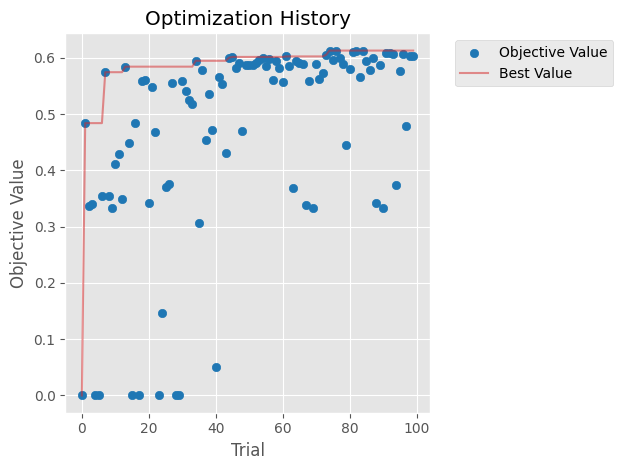

/tmp/ipykernel_8019/3310349916.py:17: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig2 = optuna.visualization.matplotlib.plot_param_importances(study)


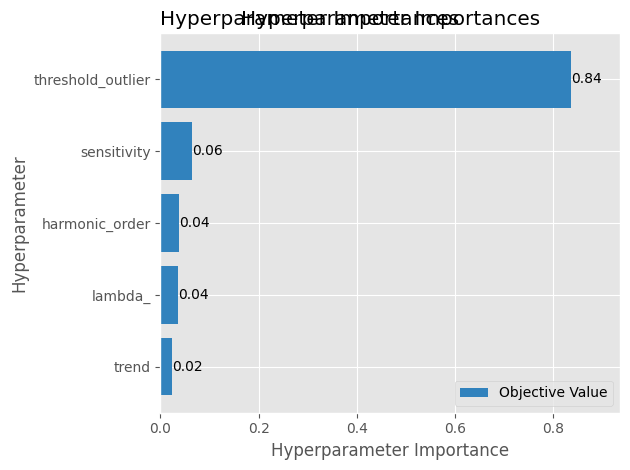

/tmp/ipykernel_8019/3310349916.py:23: ExperimentalWarning: optuna.visualization.matplotlib._parallel_coordinate.plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  fig3 = optuna.visualization.matplotlib.plot_parallel_coordinate(study)


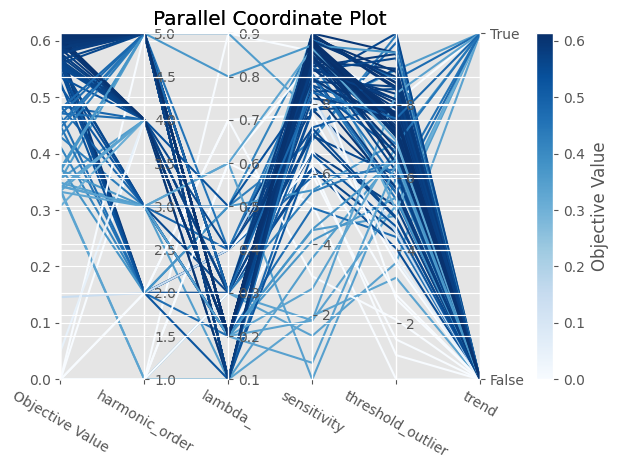

In [96]:
visualize_optimization(study_ewma)

In [88]:
def objective(trial: optuna.Trial) -> float:
    """
    Objective function for Optuna hyperparameter optimization.
    
    Args:
        trial: Optuna trial object
        
    Returns:
        Objective value to minimize (e.g., false positive rate, detection delay)
    """
    
    # Define hyperparameter search spaces
    params = {
        'trend': trial.suggest_categorical('trend', [True, False]),
        'harmonic_order': trial.suggest_int('harmonic_order', 1, 5),
        'sensitivity': trial.suggest_float('sensitivity', 0, 10.0),
        'boundary': trial.suggest_int('boundary', 1, 10),
        'L': trial.suggest_float('L', 3, 30.0),
    }
    
    # Initialize EWMA with suggested parameters
    nrt_class = CCDC(
        trend=params['trend'],
        harmonic_order=params['harmonic_order'],
        mask=mask,
        sensitivity=params['sensitivity'],
        boundary=params['boundary']
    )
    nrt_class.fit(method="OLS", dataarray=history, screen_outliers='Shewhart', L=params['L'])
    # Monitor new observations
    for array, _date in zip(monitor.values, monitor.time.values.astype('datetime64[s]').tolist()):
        nrt_class.monitor(array=array, date=_date)

    pred = pl.DataFrame(
        {
            "sample_id": ds.sample_id.values.flatten(),
            "detection_date": nrt_class.detection_date.flatten(),
        }
    ).filter(
        pl.col.sample_id!=-1
    ).with_columns(
        pred_disturbed=pl.col.detection_date!=0
    )

    results = pred.join(
        selected_samples.unique("sample_id"),
        on="sample_id"
    )

    score = f1_score(results["true_disturbed"], results["pred_disturbed"])
    return score

In [97]:
study_ewma.best_params

{'trend': False,
 'harmonic_order': 5,
 'sensitivity': 9.726387435526497,
 'lambda_': 0.2,
 'threshold_outlier': 7.165936776150536}

In [89]:
def objective(trial: optuna.Trial) -> float:
    """
    Objective function for Optuna hyperparameter optimization.
    
    Args:
        trial: Optuna trial object
        
    Returns:
        Objective value to minimize (e.g., false positive rate, detection delay)
    """
    
    # Define hyperparameter search spaces
    params = {
        'trend': trial.suggest_categorical('trend', [True, False]),
        'harmonic_order': trial.suggest_int('harmonic_order', 1, 5),
        'sensitivity': trial.suggest_float('sensitivity', 0, 10.0),
        'boundary': trial.suggest_int('boundary', 1, 10),
        'L': trial.suggest_float('L', 3, 30.0),
    }
    
    # Initialize EWMA with suggested parameters
    nrt_class = IQR(
        trend=params['trend'],
        harmonic_order=params['harmonic_order'],
        mask=mask,
        sensitivity=params['sensitivity'],
        boundary=params['boundary']
    )
    nrt_class.fit(method="OLS", dataarray=history, screen_outliers='Shewhart', L=params['L'])
    # Monitor new observations
    for array, _date in zip(monitor.values, monitor.time.values.astype('datetime64[s]').tolist()):
        nrt_class.monitor(array=array, date=_date)

    pred = pl.DataFrame(
        {
            "sample_id": ds.sample_id.values.flatten(),
            "detection_date": nrt_class.detection_date.flatten(),
        }
    ).filter(
        pl.col.sample_id!=-1
    ).with_columns(
        pred_disturbed=pl.col.detection_date!=0
    )

    results = pred.join(
        selected_samples.unique("sample_id"),
        on="sample_id"
    )

    score = f1_score(results["true_disturbed"], results["pred_disturbed"])
    return score

In [90]:
# Create study
study = optuna.create_study(
    direction="maximize",
    study_name="F1-IQR",
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Run optimization
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2025-12-29 19:28:03,680] A new study created in memory with name: F1-IQR
Best trial: 0. Best value: 0.454237:   1%|          | 1/100 [00:11<18:44, 11.36s/it]

[I 2025-12-29 19:28:15,037] Trial 0 finished with value: 0.4542372881355932 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 5.986584841970366, 'boundary': 2, 'L': 7.211852049077471}. Best is trial 0 with value: 0.4542372881355932.


Best trial: 0. Best value: 0.454237:   2%|▏         | 2/100 [00:23<19:08, 11.71s/it]

[I 2025-12-29 19:28:27,002] Trial 1 finished with value: 0.3543078412391094 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 7.080725777960454, 'boundary': 1, 'L': 29.187566008373846}. Best is trial 0 with value: 0.4542372881355932.


Best trial: 0. Best value: 0.454237:   3%|▎         | 3/100 [00:44<25:47, 15.96s/it]

[I 2025-12-29 19:28:47,996] Trial 2 finished with value: 0.4429065743944637 and parameters: {'trend': True, 'harmonic_order': 1, 'sensitivity': 1.8340450985343382, 'boundary': 4, 'L': 17.168423654070423}. Best is trial 0 with value: 0.4542372881355932.


Best trial: 0. Best value: 0.454237:   4%|▍         | 4/100 [01:13<34:07, 21.33s/it]

[I 2025-12-29 19:29:17,573] Trial 3 finished with value: 0.35248143806174287 and parameters: {'trend': True, 'harmonic_order': 4, 'sensitivity': 1.3949386065204183, 'boundary': 3, 'L': 12.891769768929676}. Best is trial 0 with value: 0.4542372881355932.


Best trial: 4. Best value: 0.464832:   5%|▌         | 5/100 [01:35<33:59, 21.47s/it]

[I 2025-12-29 19:29:39,286] Trial 4 finished with value: 0.4648318042813456 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 5.142344384136116, 'boundary': 6, 'L': 4.254161143439939}. Best is trial 4 with value: 0.4648318042813456.


Best trial: 4. Best value: 0.464832:   6%|▌         | 6/100 [02:00<35:22, 22.58s/it]

[I 2025-12-29 19:30:04,031] Trial 5 finished with value: 0.07707129094412331 and parameters: {'trend': True, 'harmonic_order': 1, 'sensitivity': 9.488855372533333, 'boundary': 10, 'L': 24.82672839914445}. Best is trial 4 with value: 0.4648318042813456.


Best trial: 4. Best value: 0.464832:   7%|▋         | 7/100 [02:23<35:15, 22.74s/it]

[I 2025-12-29 19:30:27,101] Trial 6 finished with value: 0.421455938697318 and parameters: {'trend': True, 'harmonic_order': 4, 'sensitivity': 4.4015249373960135, 'boundary': 2, 'L': 16.369776573004295}. Best is trial 4 with value: 0.4648318042813456.


Best trial: 4. Best value: 0.464832:   8%|▊         | 8/100 [02:58<40:52, 26.66s/it]

[I 2025-12-29 19:31:02,156] Trial 7 finished with value: 0.3862928348909657 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 6.62522284353982, 'boundary': 4, 'L': 17.041836571800893}. Best is trial 4 with value: 0.4648318042813456.


Best trial: 4. Best value: 0.464832:   9%|▉         | 9/100 [03:24<40:10, 26.49s/it]

[I 2025-12-29 19:31:28,256] Trial 8 finished with value: 0.1785063752276867 and parameters: {'trend': True, 'harmonic_order': 5, 'sensitivity': 7.7513282336111455, 'boundary': 10, 'L': 27.16033846154652}. Best is trial 4 with value: 0.4648318042813456.


Best trial: 4. Best value: 0.464832:  10%|█         | 10/100 [03:49<39:06, 26.07s/it]

[I 2025-12-29 19:31:53,406] Trial 9 finished with value: 0.33759772565742713 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.959828624191452, 'boundary': 1, 'L': 11.783918930608138}. Best is trial 4 with value: 0.4648318042813456.


Best trial: 10. Best value: 0.594744:  11%|█         | 11/100 [04:22<41:35, 28.04s/it]

[I 2025-12-29 19:32:25,899] Trial 10 finished with value: 0.5947441217150761 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 3.892402484616904, 'boundary': 7, 'L': 3.3918636057613933}. Best is trial 10 with value: 0.5947441217150761.


Best trial: 11. Best value: 0.598621:  12%|█▏        | 12/100 [04:53<42:25, 28.92s/it]

[I 2025-12-29 19:32:56,839] Trial 11 finished with value: 0.5986206896551725 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 3.924528921026324, 'boundary': 7, 'L': 3.100618841830033}. Best is trial 11 with value: 0.5986206896551725.


Best trial: 12. Best value: 0.62766:  13%|█▎        | 13/100 [05:14<38:41, 26.69s/it] 

[I 2025-12-29 19:33:18,394] Trial 12 finished with value: 0.6276595744680851 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 3.2938025063671996, 'boundary': 7, 'L': 3.4437565241054755}. Best is trial 12 with value: 0.6276595744680851.


Best trial: 12. Best value: 0.62766:  14%|█▍        | 14/100 [05:36<35:59, 25.11s/it]

[I 2025-12-29 19:33:39,857] Trial 13 finished with value: 0.5604551920341394 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 3.2413260896651077, 'boundary': 8, 'L': 8.692661700231486}. Best is trial 12 with value: 0.6276595744680851.


Best trial: 12. Best value: 0.62766:  15%|█▌        | 15/100 [06:01<35:38, 25.16s/it]

[I 2025-12-29 19:34:05,128] Trial 14 finished with value: 0.607190412782956 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 3.110055106977764, 'boundary': 8, 'L': 6.06011620620159}. Best is trial 12 with value: 0.6276595744680851.


Best trial: 12. Best value: 0.62766:  16%|█▌        | 16/100 [06:22<33:28, 23.91s/it]

[I 2025-12-29 19:34:26,125] Trial 15 finished with value: 0.4080604534005038 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 0.34127748827707505, 'boundary': 9, 'L': 7.800534075351651}. Best is trial 12 with value: 0.6276595744680851.


Best trial: 12. Best value: 0.62766:  17%|█▋        | 17/100 [06:44<32:06, 23.21s/it]

[I 2025-12-29 19:34:47,704] Trial 16 finished with value: 0.5979142526071842 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 2.8260740426429867, 'boundary': 6, 'L': 21.58219682265538}. Best is trial 12 with value: 0.6276595744680851.


Best trial: 12. Best value: 0.62766:  18%|█▊        | 18/100 [07:07<31:45, 23.23s/it]

[I 2025-12-29 19:35:10,978] Trial 17 finished with value: 0.36670891423743135 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 0.2389567427050796, 'boundary': 8, 'L': 11.182428205886755}. Best is trial 12 with value: 0.6276595744680851.


Best trial: 12. Best value: 0.62766:  19%|█▉        | 19/100 [07:49<39:14, 29.06s/it]

[I 2025-12-29 19:35:53,647] Trial 18 finished with value: 0.49411764705882355 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 5.587985830433143, 'boundary': 5, 'L': 6.0072796493458185}. Best is trial 12 with value: 0.6276595744680851.


Best trial: 12. Best value: 0.62766:  20%|██        | 20/100 [08:11<35:43, 26.80s/it]

[I 2025-12-29 19:36:15,167] Trial 19 finished with value: 0.5986754966887418 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 2.6622046834515745, 'boundary': 8, 'L': 9.939788369857123}. Best is trial 12 with value: 0.6276595744680851.


Best trial: 12. Best value: 0.62766:  21%|██        | 21/100 [08:32<33:00, 25.07s/it]

[I 2025-12-29 19:36:36,194] Trial 20 finished with value: 0.40570522979397783 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 4.591939617930299, 'boundary': 9, 'L': 14.7185122894957}. Best is trial 12 with value: 0.6276595744680851.


Best trial: 12. Best value: 0.62766:  22%|██▏       | 22/100 [08:53<30:57, 23.81s/it]

[I 2025-12-29 19:36:57,074] Trial 21 finished with value: 0.607190412782956 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 2.7077867281426777, 'boundary': 8, 'L': 8.908214365469762}. Best is trial 12 with value: 0.6276595744680851.


Best trial: 12. Best value: 0.62766:  23%|██▎       | 23/100 [09:06<26:20, 20.53s/it]

[I 2025-12-29 19:37:09,953] Trial 22 finished with value: 0.587431693989071 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 3.3848344546818883, 'boundary': 7, 'L': 5.658041999712893}. Best is trial 12 with value: 0.6276595744680851.


Best trial: 12. Best value: 0.62766:  24%|██▍       | 24/100 [09:19<23:04, 18.22s/it]

[I 2025-12-29 19:37:22,775] Trial 23 finished with value: 0.5981981981981982 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 1.1509041659702295, 'boundary': 9, 'L': 5.8370099582831365}. Best is trial 12 with value: 0.6276595744680851.


Best trial: 24. Best value: 0.648058:  25%|██▌       | 25/100 [09:31<20:42, 16.56s/it]

[I 2025-12-29 19:37:35,477] Trial 24 finished with value: 0.6480582524271845 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 2.2607702625758668, 'boundary': 7, 'L': 9.335067104250575}. Best is trial 24 with value: 0.6480582524271845.


Best trial: 24. Best value: 0.648058:  26%|██▌       | 26/100 [09:44<18:54, 15.33s/it]

[I 2025-12-29 19:37:47,922] Trial 25 finished with value: 0.5678793256433008 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 2.1522065954775176, 'boundary': 5, 'L': 13.990027765178446}. Best is trial 24 with value: 0.6480582524271845.


Best trial: 24. Best value: 0.648058:  27%|██▋       | 27/100 [09:57<17:53, 14.70s/it]

[I 2025-12-29 19:38:01,168] Trial 26 finished with value: 0.3595410114747131 and parameters: {'trend': True, 'harmonic_order': 2, 'sensitivity': 0.705702513819475, 'boundary': 6, 'L': 10.465106348143653}. Best is trial 24 with value: 0.6480582524271845.


Best trial: 24. Best value: 0.648058:  28%|██▊       | 28/100 [10:09<16:46, 13.98s/it]

[I 2025-12-29 19:38:13,473] Trial 27 finished with value: 0.4523076923076923 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 3.809000210507941, 'boundary': 7, 'L': 21.13189923686452}. Best is trial 24 with value: 0.6480582524271845.


Best trial: 24. Best value: 0.648058:  29%|██▉       | 29/100 [10:21<15:53, 13.43s/it]

[I 2025-12-29 19:38:25,613] Trial 28 finished with value: 0.5347826086956522 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 1.1345243319950988, 'boundary': 7, 'L': 5.067442703092691}. Best is trial 24 with value: 0.6480582524271845.


Best trial: 24. Best value: 0.648058:  30%|███       | 30/100 [10:34<15:20, 13.15s/it]

[I 2025-12-29 19:38:38,122] Trial 29 finished with value: 0.5026881720430108 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 5.424932089909999, 'boundary': 5, 'L': 7.201574767156654}. Best is trial 24 with value: 0.6480582524271845.


Best trial: 24. Best value: 0.648058:  31%|███       | 31/100 [10:47<14:55, 12.98s/it]

[I 2025-12-29 19:38:50,706] Trial 30 finished with value: 0.4454828660436137 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 4.480723392909347, 'boundary': 9, 'L': 7.3531433173457685}. Best is trial 24 with value: 0.6480582524271845.


Best trial: 24. Best value: 0.648058:  32%|███▏      | 32/100 [10:59<14:36, 12.88s/it]

[I 2025-12-29 19:39:03,355] Trial 31 finished with value: 0.6123521681997371 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 2.591907444146053, 'boundary': 8, 'L': 9.354896123170047}. Best is trial 24 with value: 0.6480582524271845.


Best trial: 24. Best value: 0.648058:  33%|███▎      | 33/100 [11:11<14:10, 12.70s/it]

[I 2025-12-29 19:39:15,627] Trial 32 finished with value: 0.6437659033078881 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 2.430784960248222, 'boundary': 8, 'L': 6.81518199742356}. Best is trial 24 with value: 0.6480582524271845.


Best trial: 33. Best value: 0.656212:  34%|███▍      | 34/100 [11:24<13:55, 12.67s/it]

[I 2025-12-29 19:39:28,213] Trial 33 finished with value: 0.6562123039806996 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 2.0260158528713097, 'boundary': 6, 'L': 9.322666228584065}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  35%|███▌      | 35/100 [11:37<13:39, 12.61s/it]

[I 2025-12-29 19:39:40,692] Trial 34 finished with value: 0.6457073760580411 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 2.0080543285176367, 'boundary': 6, 'L': 13.314745418113231}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  36%|███▌      | 36/100 [11:50<13:41, 12.83s/it]

[I 2025-12-29 19:39:54,033] Trial 35 finished with value: 0.4185478950579622 and parameters: {'trend': True, 'harmonic_order': 1, 'sensitivity': 1.6061690378928, 'boundary': 4, 'L': 13.032033665525935}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  37%|███▋      | 37/100 [12:02<13:20, 12.71s/it]

[I 2025-12-29 19:40:06,466] Trial 36 finished with value: 0.6337135614702155 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 2.274824101766764, 'boundary': 6, 'L': 19.497598010832647}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  38%|███▊      | 38/100 [12:16<13:18, 12.88s/it]

[I 2025-12-29 19:40:19,758] Trial 37 finished with value: 0.38228213769860375 and parameters: {'trend': True, 'harmonic_order': 1, 'sensitivity': 0.8025296563498863, 'boundary': 6, 'L': 15.233688129554665}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  39%|███▉      | 39/100 [12:28<12:59, 12.78s/it]

[I 2025-12-29 19:40:32,279] Trial 38 finished with value: 0.4958217270194986 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.7467332761565295, 'boundary': 3, 'L': 12.684768480592309}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  40%|████      | 40/100 [12:40<12:31, 12.53s/it]

[I 2025-12-29 19:40:44,235] Trial 39 finished with value: 0.33808695652173915 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 0.06941351090933057, 'boundary': 4, 'L': 12.018743392407785}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  41%|████      | 41/100 [12:54<12:35, 12.81s/it]

[I 2025-12-29 19:40:57,683] Trial 40 finished with value: 0.4370607028753994 and parameters: {'trend': True, 'harmonic_order': 1, 'sensitivity': 1.4362955279717324, 'boundary': 5, 'L': 10.87704634793187}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  42%|████▏     | 42/100 [13:07<12:37, 13.05s/it]

[I 2025-12-29 19:41:11,319] Trial 41 finished with value: 0.6264441591784339 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 2.4231090996378017, 'boundary': 6, 'L': 19.260119807039516}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  43%|████▎     | 43/100 [13:20<12:14, 12.88s/it]

[I 2025-12-29 19:41:23,795] Trial 42 finished with value: 0.6412395709177592 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.958724186099559, 'boundary': 6, 'L': 18.703240382826195}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  44%|████▍     | 44/100 [13:46<15:55, 17.06s/it]

[I 2025-12-29 19:41:50,597] Trial 43 finished with value: 0.6327827191867853 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 2.0039745566120164, 'boundary': 7, 'L': 17.742251235967817}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  45%|████▌     | 45/100 [13:56<13:34, 14.80s/it]

[I 2025-12-29 19:42:00,140] Trial 44 finished with value: 0.12429378531073447 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 9.740839602637283, 'boundary': 6, 'L': 16.031837601120785}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  46%|████▌     | 46/100 [14:04<11:33, 12.83s/it]

[I 2025-12-29 19:42:08,381] Trial 45 finished with value: 0.2390158172231986 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 7.73429103191896, 'boundary': 5, 'L': 23.875216395766238}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  47%|████▋     | 47/100 [14:12<10:05, 11.42s/it]

[I 2025-12-29 19:42:16,506] Trial 46 finished with value: 0.540090771558245 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 0.9063098957145772, 'boundary': 7, 'L': 18.20010800700484}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  48%|████▊     | 48/100 [14:20<09:00, 10.40s/it]

[I 2025-12-29 19:42:24,528] Trial 47 finished with value: 0.5765027322404371 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 3.7195034331262784, 'boundary': 6, 'L': 7.993866941056352}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  49%|████▉     | 49/100 [14:32<09:12, 10.84s/it]

[I 2025-12-29 19:42:36,395] Trial 48 finished with value: 0.1981981981981982 and parameters: {'trend': True, 'harmonic_order': 1, 'sensitivity': 6.285268944017153, 'boundary': 10, 'L': 29.95365682648209}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  50%|█████     | 50/100 [14:44<09:14, 11.08s/it]

[I 2025-12-29 19:42:48,035] Trial 49 finished with value: 0.437465564738292 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 1.6481443576488948, 'boundary': 3, 'L': 13.812461205206198}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  51%|█████     | 51/100 [14:56<09:11, 11.25s/it]

[I 2025-12-29 19:42:59,693] Trial 50 finished with value: 0.5480631276901005 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 3.0712888355565484, 'boundary': 7, 'L': 11.846501871384246}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  52%|█████▏    | 52/100 [15:05<08:29, 10.62s/it]

[I 2025-12-29 19:43:08,842] Trial 51 finished with value: 0.6375 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 2.19937278234852, 'boundary': 6, 'L': 19.871044273497777}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  53%|█████▎    | 53/100 [15:15<08:13, 10.50s/it]

[I 2025-12-29 19:43:19,040] Trial 52 finished with value: 0.6336154776299879 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 2.3250922300753682, 'boundary': 5, 'L': 22.95428337877517}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  54%|█████▍    | 54/100 [15:27<08:22, 10.91s/it]

[I 2025-12-29 19:43:30,935] Trial 53 finished with value: 0.5827338129496403 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.2873646448909306, 'boundary': 6, 'L': 19.948919502684635}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  55%|█████▌    | 55/100 [15:38<08:16, 11.03s/it]

[I 2025-12-29 19:43:42,229] Trial 54 finished with value: 0.6202247191011236 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 1.9225117429339638, 'boundary': 7, 'L': 16.09597803035685}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  56%|█████▌    | 56/100 [15:48<07:48, 10.64s/it]

[I 2025-12-29 19:43:51,977] Trial 55 finished with value: 0.5391304347826087 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 2.90572811461104, 'boundary': 8, 'L': 27.814838868322383}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  57%|█████▋    | 57/100 [15:56<07:07,  9.94s/it]

[I 2025-12-29 19:44:00,271] Trial 56 finished with value: 0.375 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 0.47289770360690175, 'boundary': 6, 'L': 18.097573079700652}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  58%|█████▊    | 58/100 [16:06<06:57,  9.94s/it]

[I 2025-12-29 19:44:10,223] Trial 57 finished with value: 0.6192017259978425 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 3.3108511411717307, 'boundary': 5, 'L': 4.373571575591053}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  59%|█████▉    | 59/100 [16:15<06:41,  9.79s/it]

[I 2025-12-29 19:44:19,668] Trial 58 finished with value: 0.20863309352517986 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 8.83224760238393, 'boundary': 8, 'L': 6.766244581949428}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  60%|██████    | 60/100 [16:23<06:08,  9.21s/it]

[I 2025-12-29 19:44:27,504] Trial 59 finished with value: 0.5514511873350924 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 3.573756000831848, 'boundary': 4, 'L': 20.62581363095786}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  61%|██████    | 61/100 [16:31<05:41,  8.75s/it]

[I 2025-12-29 19:44:35,186] Trial 60 finished with value: 0.6323907455012854 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 2.1510039568227044, 'boundary': 7, 'L': 10.091231431576826}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  62%|██████▏   | 62/100 [16:39<05:21,  8.45s/it]

[I 2025-12-29 19:44:42,953] Trial 61 finished with value: 0.6229086229086229 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 2.4360280005710813, 'boundary': 6, 'L': 19.260257234080306}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  63%|██████▎   | 63/100 [16:47<05:10,  8.40s/it]

[I 2025-12-29 19:44:51,227] Trial 62 finished with value: 0.6391061452513966 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.747654391441749, 'boundary': 6, 'L': 22.182928300266923}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  64%|██████▍   | 64/100 [16:55<04:56,  8.23s/it]

[I 2025-12-29 19:44:59,049] Trial 63 finished with value: 0.6032660902977905 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.4008557098631986, 'boundary': 6, 'L': 21.80421117156816}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  65%|██████▌   | 65/100 [17:03<04:43,  8.11s/it]

[I 2025-12-29 19:45:06,890] Trial 64 finished with value: 0.6108786610878661 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.7862457737510362, 'boundary': 5, 'L': 22.22675332939879}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  66%|██████▌   | 66/100 [17:11<04:35,  8.10s/it]

[I 2025-12-29 19:45:14,977] Trial 65 finished with value: 0.47832585949177875 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 4.168906438364384, 'boundary': 7, 'L': 25.89727955313338}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  67%|██████▋   | 67/100 [17:19<04:25,  8.03s/it]

[I 2025-12-29 19:45:22,841] Trial 66 finished with value: 0.6141522029372497 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 2.8519048172072363, 'boundary': 6, 'L': 8.410833711509332}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  68%|██████▊   | 68/100 [17:27<04:18,  8.09s/it]

[I 2025-12-29 19:45:31,079] Trial 67 finished with value: 0.42016806722689076 and parameters: {'trend': True, 'harmonic_order': 2, 'sensitivity': 1.0874229255629362, 'boundary': 8, 'L': 24.14213497430789}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  69%|██████▉   | 69/100 [17:35<04:11,  8.10s/it]

[I 2025-12-29 19:45:39,199] Trial 68 finished with value: 0.35584843492586493 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 4.922638955546417, 'boundary': 9, 'L': 9.323222064902254}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  70%|███████   | 70/100 [17:43<04:03,  8.12s/it]

[I 2025-12-29 19:45:47,377] Trial 69 finished with value: 0.45125348189415043 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 0.583091048617068, 'boundary': 7, 'L': 17.300380004451384}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  71%|███████   | 71/100 [17:51<03:54,  8.09s/it]

[I 2025-12-29 19:45:55,389] Trial 70 finished with value: 0.574826560951437 and parameters: {'trend': False, 'harmonic_order': 5, 'sensitivity': 2.599220170666903, 'boundary': 6, 'L': 20.269411294526744}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  72%|███████▏  | 72/100 [17:59<03:46,  8.08s/it]

[I 2025-12-29 19:46:03,439] Trial 71 finished with value: 0.6365914786967418 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 2.206482902712135, 'boundary': 6, 'L': 19.06200808804192}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  73%|███████▎  | 73/100 [18:07<03:36,  8.03s/it]

[I 2025-12-29 19:46:11,347] Trial 72 finished with value: 0.6259711431742508 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.9893468986012979, 'boundary': 5, 'L': 18.481942957195688}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  74%|███████▍  | 74/100 [18:15<03:27,  7.99s/it]

[I 2025-12-29 19:46:19,260] Trial 73 finished with value: 0.6370530877573131 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.678500746058322, 'boundary': 6, 'L': 22.464135361690623}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  75%|███████▌  | 75/100 [18:23<03:20,  8.01s/it]

[I 2025-12-29 19:46:27,301] Trial 74 finished with value: 0.6519823788546255 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.5150042940446276, 'boundary': 7, 'L': 6.435805603993645}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  76%|███████▌  | 76/100 [18:31<03:12,  8.02s/it]

[I 2025-12-29 19:46:35,362] Trial 75 finished with value: 0.34110685694396103 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.4277994434645362, 'boundary': 1, 'L': 6.49001828810498}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  77%|███████▋  | 77/100 [18:39<03:05,  8.05s/it]

[I 2025-12-29 19:46:43,477] Trial 76 finished with value: 0.5128900949796472 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 1.0275760751978262, 'boundary': 7, 'L': 4.89594400491454}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  78%|███████▊  | 78/100 [18:48<03:01,  8.26s/it]

[I 2025-12-29 19:46:52,236] Trial 77 finished with value: 0.5168831168831168 and parameters: {'trend': True, 'harmonic_order': 1, 'sensitivity': 2.9769764172494466, 'boundary': 8, 'L': 7.498881111094488}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  79%|███████▉  | 79/100 [18:56<02:51,  8.18s/it]

[I 2025-12-29 19:47:00,209] Trial 78 finished with value: 0.6059850374064838 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 2.5443203919443227, 'boundary': 7, 'L': 21.11096654138554}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  80%|████████  | 80/100 [19:04<02:42,  8.10s/it]

[I 2025-12-29 19:47:08,146] Trial 79 finished with value: 0.5039370078740157 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 0.7284083445578657, 'boundary': 7, 'L': 9.55948994843318}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  81%|████████  | 81/100 [19:12<02:34,  8.13s/it]

[I 2025-12-29 19:47:16,328] Trial 80 finished with value: 0.6476190476190476 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.547505410557636, 'boundary': 8, 'L': 11.031137225918183}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  82%|████████▏ | 82/100 [19:20<02:25,  8.07s/it]

[I 2025-12-29 19:47:24,278] Trial 81 finished with value: 0.6450060168471721 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.5861366007933262, 'boundary': 8, 'L': 11.108154578736992}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  83%|████████▎ | 83/100 [19:28<02:17,  8.06s/it]

[I 2025-12-29 19:47:32,311] Trial 82 finished with value: 0.6370370370370371 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.5361663487180166, 'boundary': 9, 'L': 11.075282304858852}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  84%|████████▍ | 84/100 [19:36<02:10,  8.13s/it]

[I 2025-12-29 19:47:40,605] Trial 83 finished with value: 0.6283524904214559 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.8290324757418395, 'boundary': 8, 'L': 12.600246072551876}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  85%|████████▌ | 85/100 [19:45<02:03,  8.21s/it]

[I 2025-12-29 19:47:49,005] Trial 84 finished with value: 0.6206115515288788 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.2983292024319575, 'boundary': 9, 'L': 10.441172078908199}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  86%|████████▌ | 86/100 [19:53<01:54,  8.18s/it]

[I 2025-12-29 19:47:57,105] Trial 85 finished with value: 0.5321375186846039 and parameters: {'trend': False, 'harmonic_order': 3, 'sensitivity': 0.9953440017454109, 'boundary': 8, 'L': 8.389078259594289}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  87%|████████▋ | 87/100 [20:01<01:47,  8.24s/it]

[I 2025-12-29 19:48:05,483] Trial 86 finished with value: 0.35266999615827893 and parameters: {'trend': False, 'harmonic_order': 4, 'sensitivity': 0.10257436830923994, 'boundary': 8, 'L': 13.456557726827686}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  88%|████████▊ | 88/100 [20:11<01:42,  8.58s/it]

[I 2025-12-29 19:48:14,855] Trial 87 finished with value: 0.6318471337579618 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 2.0106173096007645, 'boundary': 7, 'L': 14.741205403713941}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  89%|████████▉ | 89/100 [20:19<01:34,  8.64s/it]

[I 2025-12-29 19:48:23,621] Trial 88 finished with value: 0.4268733850129199 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 0.39780083756275086, 'boundary': 8, 'L': 12.43250832224923}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  90%|█████████ | 90/100 [20:32<01:38,  9.83s/it]

[I 2025-12-29 19:48:36,239] Trial 89 finished with value: 0.48205128205128206 and parameters: {'trend': True, 'harmonic_order': 2, 'sensitivity': 1.583418033745273, 'boundary': 9, 'L': 8.958205150189626}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  91%|█████████ | 91/100 [20:44<01:33, 10.35s/it]

[I 2025-12-29 19:48:47,788] Trial 90 finished with value: 0.6085232903865213 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.2861848632853061, 'boundary': 7, 'L': 11.270956157216583}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  92%|█████████▏| 92/100 [20:55<01:25, 10.65s/it]

[I 2025-12-29 19:48:59,157] Trial 91 finished with value: 0.6483790523690773 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 2.224598339631848, 'boundary': 6, 'L': 9.98020192991266}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  93%|█████████▎| 93/100 [21:04<01:10, 10.12s/it]

[I 2025-12-29 19:49:08,030] Trial 92 finished with value: 0.6317135549872123 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 2.3898387585983127, 'boundary': 6, 'L': 11.59910689891965}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  94%|█████████▍| 94/100 [21:14<01:01, 10.23s/it]

[I 2025-12-29 19:49:18,528] Trial 93 finished with value: 0.6183206106870229 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 2.777736962078802, 'boundary': 5, 'L': 9.750382004538887}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  95%|█████████▌| 95/100 [21:23<00:48,  9.76s/it]

[I 2025-12-29 19:49:27,178] Trial 94 finished with value: 0.6522262334536703 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.9977139642154988, 'boundary': 6, 'L': 10.427265516961148}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  96%|█████████▌| 96/100 [21:32<00:37,  9.47s/it]

[I 2025-12-29 19:49:35,973] Trial 95 finished with value: 0.6266318537859008 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 1.9607275964050985, 'boundary': 8, 'L': 10.171778065902595}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  97%|█████████▋| 97/100 [21:40<00:27,  9.09s/it]

[I 2025-12-29 19:49:44,173] Trial 96 finished with value: 0.5380281690140845 and parameters: {'trend': False, 'harmonic_order': 2, 'sensitivity': 3.4646981168094024, 'boundary': 7, 'L': 10.908680589107966}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  98%|█████████▊| 98/100 [21:48<00:17,  8.84s/it]

[I 2025-12-29 19:49:52,430] Trial 97 finished with value: 0.6434108527131783 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 2.665079533702638, 'boundary': 6, 'L': 7.84994954939817}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212:  99%|█████████▉| 99/100 [21:57<00:08,  8.67s/it]

[I 2025-12-29 19:50:00,698] Trial 98 finished with value: 0.5961538461538461 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 3.253793424422529, 'boundary': 6, 'L': 7.00143428429668}. Best is trial 33 with value: 0.6562123039806996.


Best trial: 33. Best value: 0.656212: 100%|██████████| 100/100 [22:05<00:00, 13.25s/it]

[I 2025-12-29 19:50:09,036] Trial 99 finished with value: 0.6059782608695652 and parameters: {'trend': False, 'harmonic_order': 1, 'sensitivity': 2.6840072949091165, 'boundary': 7, 'L': 7.931586941501543}. Best is trial 33 with value: 0.6562123039806996.


/tmp/ipykernel_8019/3310349916.py:11: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig1 = optuna.visualization.matplotlib.plot_optimization_history(study)


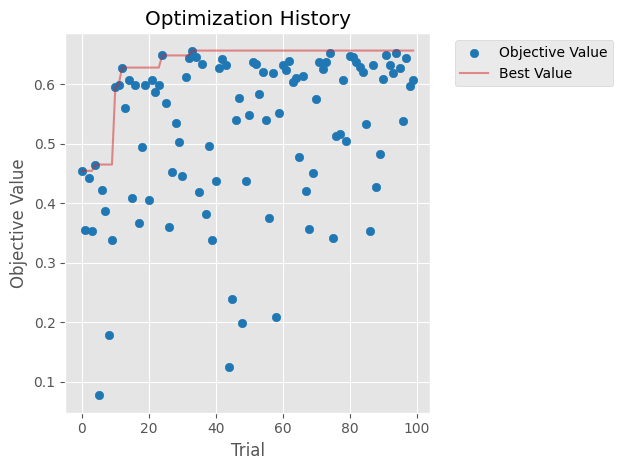

/tmp/ipykernel_8019/3310349916.py:17: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig2 = optuna.visualization.matplotlib.plot_param_importances(study)


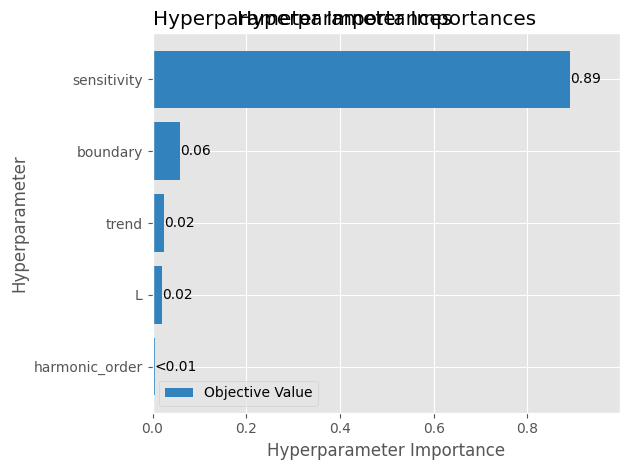

/tmp/ipykernel_8019/3310349916.py:23: ExperimentalWarning: optuna.visualization.matplotlib._parallel_coordinate.plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  fig3 = optuna.visualization.matplotlib.plot_parallel_coordinate(study)


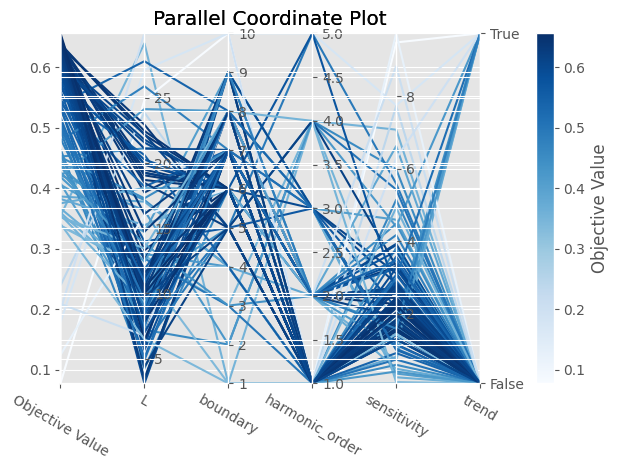

In [91]:
visualize_optimization(study)

In [92]:
study.best_params

{'trend': False,
 'harmonic_order': 1,
 'sensitivity': 2.0260158528713097,
 'boundary': 6,
 'L': 9.322666228584065}